In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from IPython.display import display
def display_matrix(m):
    display(sympy.Matrix(m))
import sympy

sympy.init_printing()

In [2]:
S0 = 100
T = 1
mu = 0.05
sigma = 0.2
lam = 1
I = 100
m = 0
v = 0.3
paths = 100
K = 99
df = np.exp(-mu*T)

In [7]:
def matrix(paths):
    np.random.seed(42)
    matrix = np.zeros((paths, I))
    for k in range(paths):
        X = np.zeros(I)
        S = np.zeros(I)

        X[0] = np.log(S0)
        S[0] = S0
        dt = T / I
    
        for i in range(1,I):
            Z = np.random.standard_normal()
            N = np.random.poisson(lam * dt)
            Y = np.exp(np.random.normal(m,v,N))
    
            if N == 0:
                M = 0
    
            else:
                for j in range(N):
                    M = np.sum(np.log(Y))
                    
            X[i] = X[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z + M
            S[i] = np.exp(X[i])
        matrix[k] = S
    return matrix

S = matrix(paths)
S.shape

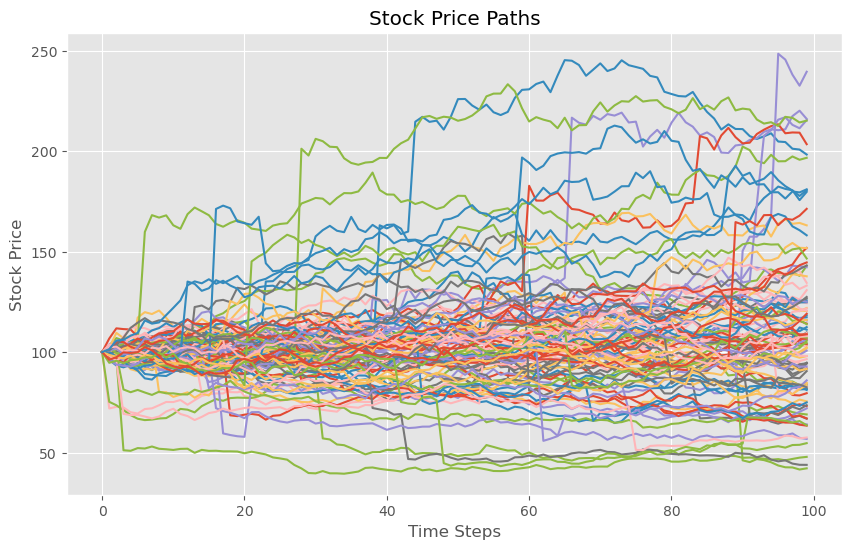

In [10]:
#plot the paths
plt.figure(figsize=(10,6))
plt.plot(S.T)
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Stock Price Paths')
plt.show()

In [4]:
def LSM(K, S, I, df, basis):
    H = np.maximum(K - S, 0)  # intrinsic values for put option
    V = np.zeros_like(H)  # value matrix
    V[:, -1] = H[:, -1] # set value at maturity equal to intrinsic value
    np.random.seed(42)
    # Valuation by LS Method
    for t in range(I - 2, 0, -1): #start at t = I-2 and go backwards (since we already set t = I-1 to intrinsic value)
        good_paths = H[:, t] > 0  # paths where the intrinsic value is positive
        # the regression is performed only on these paths
        if basis == 'poly':
            rg = np.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, 3)  # polynomial regression
            C = np.polyval(rg, S[good_paths, t])  # evaluation of regression
        elif basis == 'legendre':
            rg = np.polynomial.legendre.legfit(S[good_paths, t], V[good_paths, t + 1] * df, 3)
            C = np.polynomial.legendre.legval(S[good_paths, t], rg)
        else:
            rg = np.polynomial.hermite.hermfit(S[good_paths, t], V[good_paths, t + 1] * df, 3)
            C = np.polynomial.hermite.hermval(S[good_paths, t], rg)

        exercise = np.zeros(len(good_paths), dtype=bool)  # initialize
        exercise[good_paths] = H[good_paths, t] > C  # paths where it is optimal to exercise

        V[exercise, t] = H[exercise, t]  # set V equal to H where it is optimal to exercise
        V[exercise, t + 1 :] = 0  # set future cash flows, for that path, equal to zero
        discount_path = V[:, t] == 0  # paths where we didn't exercise
        V[discount_path, t] = V[discount_path, t + 1] * df  # set V[t] in continuation region

    V0 = np.mean(V[:, 1]) * df  # discounted expectation of V[t=1]
    print('The value of the American put option is: ', V0)
    return V0

In [5]:
for basis in ('poly', 'legendre', 'hermite'):
          LSM(K, S, I, df, basis)

The value of the American put option is:  3.6767062892308218
The value of the American put option is:  3.6767062892308218
The value of the American put option is:  3.6767062892308218
